In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [13]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [24]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
audio_file_path = 'audios/berlin1.wav'
pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print('Harmonic component:')
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print('Percussive component:')
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


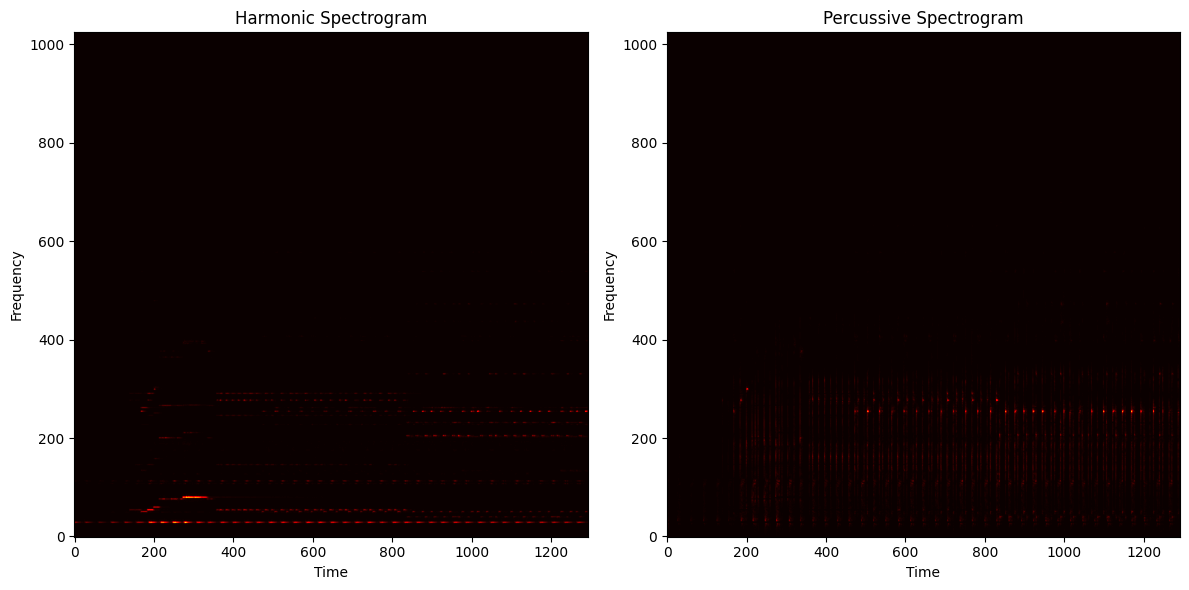

In [25]:
plt.figure(figsize=(12, 6))

# Plot harmonic spectrogram
plt.subplot(1, 2, 1)
plt.imshow(harmonic, aspect='auto', origin='lower', cmap='hot')
plt.title('Harmonic Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

# Plot percussive spectrogram
plt.subplot(1, 2, 2)
plt.imshow(percussive, aspect='auto', origin='lower', cmap='hot')
plt.title('Percussive Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

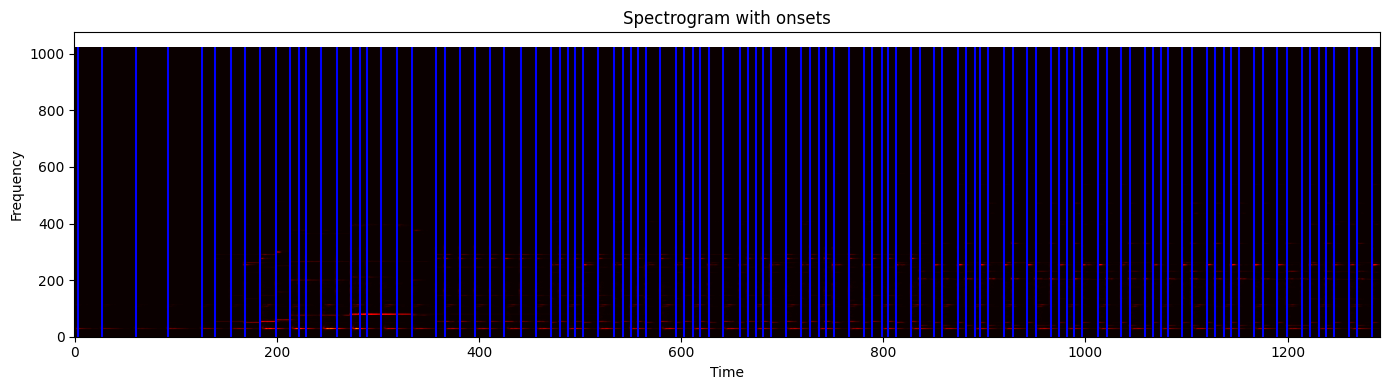

In [26]:
# Assuming you have already computed 'percussive_audio', 'sr', and 'spectrogram'

onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='hot')

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color='blue', linestyle='-')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram with onsets')

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [27]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [28]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(harmonic_audio, sr)

94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step


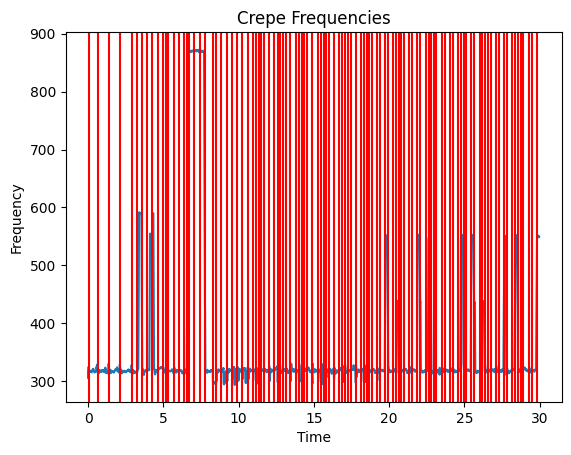

In [29]:
# Plot the interpolated frequencies
plt.plot(time, frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Crepe Frequencies')

for t in onsets:
    plt.axvline(x=round(t, 2), color='r', linestyle='-', label=f'Time {t}')

plt.show()

In [43]:
tones = []
for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1: index_b = len(time) - 1
    else: index_b = np.argmax(time > onsets[i+1])
    frequency_range = frequency[index_a:index_b]
    tone = np.median(frequency_range)
    print(f'Onset {i}-{i+1}: {tone}')
    tones.append(tone)

Onset 0-1: 317.1931888935505
Onset 1-2: 316.8819890336612
Onset 2-3: 317.9335216028937
Onset 3-4: 317.16692892854957
Onset 4-5: 315.9173934575548
Onset 5-6: 539.6918325574861
Onset 6-7: 317.6915929550146
Onset 7-8: 378.69134594695515
Onset 8-9: 318.8012962366056
Onset 9-10: 322.24249099563315
Onset 10-11: 319.04155625723945
Onset 11-12: 316.54309575107993
Onset 12-13: 317.67410607027443
Onset 13-14: 318.0435751420735
Onset 14-15: 317.4404015658974
Onset 15-16: 317.9093092943906
Onset 16-17: 813.0174551650393
Onset 17-18: 869.901841929
Onset 18-19: 870.6541840096695
Onset 19-20: 869.7556977465979
Onset 20-21: 317.0160476375102
Onset 21-22: 296.4835014250952
Onset 22-23: 317.4653843586806
Onset 23-24: 315.24285835672873
Onset 24-25: 318.5497729071133
Onset 25-26: 317.82392484826175
Onset 26-27: 317.9576810353128
Onset 27-28: 317.16130001332346
Onset 28-29: 317.932667970928
Onset 29-30: 318.4182415480443
Onset 30-31: 299.33024697046625
Onset 31-32: 317.22501974460306
Onset 32-33: 318.3217

In [44]:
def group_and_average_frequencies(frequencies, threshold=3):
    frequencies = sorted(frequencies)
    grouped_frequencies = []
    current_group = [frequencies[0]]
    
    for i in range(1, len(frequencies)):
        if frequencies[i] - frequencies[i-1] <= threshold:
            current_group.append(frequencies[i])
        else:
            grouped_frequencies.append(sum(current_group) / len(current_group))
            current_group = [frequencies[i]]
    
    grouped_frequencies.append(sum(current_group) / len(current_group))
    
    return grouped_frequencies

In [45]:
grouped_averaged_frequencies = group_and_average_frequencies(tones)
print(grouped_averaged_frequencies)

[300.096959245409, 317.92847165621106, 378.69134594695515, 436.12369519183255, 510.1774909603469, 539.6918325574861, 549.7613571520061, 813.0174551650393, 870.1039078950893]


In [46]:
for tone in grouped_averaged_frequencies:
    audio = librosa.tone(tone, duration=1)
    display(ipd.Audio(audio, rate=sr))